# Project ABS
The goal of this notebook will be to explore data compiled from the Australian Bureau of Statistics (ABS) compiled as part of their [AUSSTATS](https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1410.02013-18?OpenDocument) documentation, looking at trends across a wide variety of "key measures" by geographical region within Australia.

Preliminarily I am interested in exploring ties between income and age (for potential use in later analysis on tax effects on different generations), but there are also some interesting factoids regarding solar panel installations which have piqued my curiousity.

Note all files were originally ".xls" format, and have had incredibly minor alterations as follows:
* Removing "branding" and "page header" rows (rows 1-5 in source document)
* Removing "Copyright" and empty "footer" columns at the end of the dataset
* Consolidating all the details outlined in the column headers into 1 header per column (removing merged formatting and cross filling for empty cells)
* Saving each document as .csv

All files are based on the ASGS (Australian Statistical Geography Standard) location methodology. There is potential of further exploration based on documents located [here](https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1270.0.55.003July%202011?OpenDocument).

In [39]:
# Declare Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import os
from textwrap import wrap
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


sns.reset_orig()

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [40]:
# Set a variable for current notebook's path for various loading/saving mechanisms
nb_path = os.getcwd()
nb_path

'C:\\Users\\kempbri\\OneDrive - Mars Inc\\GitHub\\ABS-Region-Data'

In [41]:
# Import the files for exploration
# Note: could optimize to import all the CSVs from that directory, not sure how to assign distinct dataframes 
# for each off the top of my head.
df_income = pd.read_csv('{}\CSV\Income_ASGS_Final.csv'.format(nb_path), na_values='-', thousands=',')
df_pop = pd.read_csv('{}\CSV\Population and People_ASGS.csv'.format(nb_path), na_values='-', thousands=',')
df_solar = pd.read_csv('{}\CSV\Land and Environment_ASGS.csv'.format(nb_path), na_values='-', thousands=',')
df_fam = pd.read_csv('{}\CSV\Family and Community_ASGS.csv'.format(nb_path), na_values='-', thousands=',')

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
keep_cols = ['CODE',
             'LABEL',
             'YEAR',
             'SOLAR INSTALLATIONS Small-Scale Solar Panel System Installations no.']

drop_cols = []

for column in df_solar.columns:
    if not(column in keep_cols):
        drop_cols.append(column)

In [43]:
df_solar.drop(drop_cols,axis=1,inplace=True)

In [44]:
# For the purposes of this analysis, I'm only going to be looking at the most granular data.
# This is in order to get the greatest number of unique data points for any ML to be applied.
# Therefore we can drop any records with "CODE" length < 9. 
df_income.drop(df_income[df_income['CODE'].astype(str).map(len) <= 8].index, inplace=True)
df_solar.drop(df_income[df_income['CODE'].astype(str).map(len) <= 8].index, inplace=True)
df_fam.drop(df_income[df_income['CODE'].astype(str).map(len) <= 8].index, inplace=True)
df_pop.drop(df_income[df_income['CODE'].astype(str).map(len) <= 8].index, inplace=True)

In [45]:
# Merge the dataframes together for analysis
df = pd.merge(df_income, df_solar, how='inner', left_on=['CODE','YEAR','LABEL'], right_on=['CODE','YEAR','LABEL'])

cols_to_use = df_pop.columns.difference(df.columns).tolist()
cols_to_use.extend(['CODE','YEAR','LABEL'])

df = pd.merge(df, df_pop[cols_to_use], how='inner', left_on=['CODE','YEAR','LABEL'], right_on=['CODE','YEAR','LABEL'])

cols_to_use = df_fam.columns.difference(df.columns).tolist()
cols_to_use.extend(['CODE','YEAR','LABEL'])

df = pd.merge(df, df_fam, how='inner', left_on=['CODE','YEAR','LABEL'], right_on=['CODE','YEAR','LABEL'])

df.head()

,CODE,LABEL,YEAR,ESTIMATES OF PERSONAL INCOME Employee income earners no.,ESTIMATES OF PERSONAL INCOME Employee income earners - median age years,ESTIMATES OF PERSONAL INCOME Total Employee income $,ESTIMATES OF PERSONAL INCOME Median Employee income $,ESTIMATES OF PERSONAL INCOME Mean Employee income $,ESTIMATES OF PERSONAL INCOME Employee income as main source of income %,ESTIMATES OF PERSONAL INCOME Own unincorporated business income earners no.,...,COMMUTING TO WORK Average commuting distance from Place of Usual Residence - Year 10 and above kms,COMMUTING TO WORK Average commuting distance from Place of Usual Residence - Year 9 and below kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Postgraduate Degree kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Graduate Diploma and Graduate Cert kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Bachelor Degree kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Advanced Diploma and Diploma kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Certificate III & IV kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Certificate I & II kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Year 10 and above kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Year 9 and below kms
0,101021007,Braidwood,2014,1595.0,44.0,77935375.0,41233.0,48862.0,64.2,753.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101021007,Braidwood,2015,1641.0,44.0,83909804.0,42960.0,51133.0,62.9,747.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101021007,Braidwood,2016,1652.0,44.0,90828866.0,45312.0,54981.0,63.3,728.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,101021008,Karabar,2014,4690.0,40.0,268993415.0,54157.0,57355.0,85.2,463.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,101021008,Karabar,2015,4806.0,40.0,283280414.0,55369.0,58943.0,84.5,469.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Add in multi-index?
df.set_index(['CODE', 'LABEL', 'YEAR'], inplace=True)

df.head()

ESTIMATES OF PERSONAL INCOME Employee income earners no.  \
CODE      LABEL     YEAR                                                             
101021007 Braidwood 2014                                             1595.0          
                    2015                                             1641.0          
                    2016                                             1652.0          
101021008 Karabar   2014                                             4690.0          
                    2015                                             4806.0          

                          ESTIMATES OF PERSONAL INCOME Employee income earners - median age  years  \
CODE      LABEL     YEAR                                                                             
101021007 Braidwood 2014                                               44.0                          
                    2015                                               44.0                          
                    2016                                               44.0                          
101021008 Karabar   2014                                               40.0                          
                    2015                                               40.0                          

                          ESTIMATES OF PERSONAL INCOME Total Employee income $  \
CODE      LABEL     YEAR                                                         
101021007 Braidwood 2014                                         77935375.0      
                    2015                                         83909804.0      
                    2016                                         90828866.0      
101021008 Karabar   2014                                        268993415.0      
                    2015                                        283280414.0      

                          ESTIMATES OF PERSONAL INCOME Median Employee income $  \
CODE      LABEL     YEAR                                                          
101021007 Braidwood 2014                                            41233.0       
                    2015                                            42960.0       
                    2016                                            45312.0       
101021008 Karabar   2014                                            54157.0       
                    2015                                            55369.0       

                          ESTIMATES OF PERSONAL INCOME Mean Employee income $  \
CODE      LABEL     YEAR                                                        
101021007 Braidwood 2014                                            48862.0     
                    2015                                            51133.0     
                    2016                                            54981.0     
101021008 Karabar   2014                                            57355.0     
                    2015                                            58943.0     

                          ESTIMATES OF PERSONAL INCOME Employee income as main source of income %  \
CODE      LABEL     YEAR                                                                            
101021007 Braidwood 2014                                               64.2                         
                    2015                                               62.9                         
                    2016                                               63.3                         
101021008 Karabar   2014                                               85.2                         
                    2015                                               84.5                         

                          ESTIMATES OF PERSONAL INCOME Own unincorporated business income earners no.  \
CODE      LABEL     YEAR                                                                                
101021007 Braidwood 2014                                         

In [8]:
df.columns

Index(['CODE', 'LABEL', 'YEAR',
       'ESTIMATES OF PERSONAL INCOME Employee income earners no.',
       'ESTIMATES OF PERSONAL INCOME Employee income earners - median age  years',
       'ESTIMATES OF PERSONAL INCOME Total Employee income $',
       'ESTIMATES OF PERSONAL INCOME Median Employee income $',
       'ESTIMATES OF PERSONAL INCOME Mean Employee income $',
       'ESTIMATES OF PERSONAL INCOME Employee income as main source of income %',
       'ESTIMATES OF PERSONAL INCOME Own unincorporated business income earners no.',
       'ESTIMATES OF PERSONAL INCOME Own unincorporated business income earners - median age  years',
       'ESTIMATES OF PERSONAL INCOME Total Own unincorporated business income $',
       'ESTIMATES OF PERSONAL INCOME Median Own unincorporated business income $',
       'ESTIMATES OF PERSONAL INCOME Mean Own unincorporated business income $',
       'ESTIMATES OF PERSONAL INCOME Own unincorporated business income as main source of income  %',
       'EST

In [127]:
def sort_series_abs(S):
    'Takes a pandas Series object and returns the series sorted by absolute value'
    temp_df = pd.DataFrame(S)
    temp_df['abs'] = temp_df.iloc[:,0].abs()
    temp_df.sort_values('abs', ascending = False, inplace = True)
    return temp_df.iloc[:,0]

In [10]:
def plot_bar_comparisons(df, num_cols):
    '''
    Takes a dataframe object and plots each row as a bar chart using the index as the 
    chart title and the other columns as X-axis labels, wihtin a 5x(n/5) subplot frame
    df: dataframe object with values from which you want a chart of each row
    num_cols: the number of charts per output row
    '''
    rows = df.shape[0]
    columns = df.shape[1]
    fig, axs = plt.subplots(nrows = int(rows/num_cols + rows%num_cols), ncols = num_cols, sharey = True,
                           figsize=(15,int(rows*0.66)))
    i=1
    for row in axs:
        for ax in row:
            if i <= rows:
                sns.barplot(data = df.iloc[i-1:i,:], ax = ax)
                ax.title.set_text(df.index[i-1])
            else:
                ax.axis('off')
            i += 1
    plt.tight_layout()    
    plt.show()

In [115]:
# For fun exploration, let's just run a histogram over everything!
def histo_plots(df, num_cols):
    '''
    Takes a dataframe object and plots each column as a histogram chart using the feature title as the 
    chart title and the other columns as X-axis labels, within an n*(len/n) subplot frame
    df: dataframe object with values from which you want a chart of each row
    num_cols: the number of charts per output row
    '''
    rows = df.shape[0]
    columns = df.shape[1]
    plot_rows = (int(columns/num_cols) + ((columns%num_cols)!=0))
    fig, axs = plt.subplots(nrows = plot_rows, 
                            ncols = num_cols, sharey = False, figsize=(15,columns))
    nlines = 1

    for i in range(axs.shape[0]*axs.shape[1]):
        #print(i)
        if i < columns:
            try:
                df.iloc[:,i].dropna().plot.hist(ax = axs[int(i/num_cols),int(i%num_cols)])
                axs[int(i/num_cols),i%num_cols].set_title("\n".join(wrap(df.columns[i], int(100/num_cols))))
                nlines = max(nlines,axs[int(i/num_cols),int(i%num_cols)].get_title().count('\n'))
            
            except:
                axs[int(i/num_cols),i%num_cols].set_title("\n".join(wrap(df.columns[i], 100/num_cols)))
                axs[int(i/num_cols),i%num_cols].axis('off')
        else:
            axs[int(i/num_cols),int(i%num_cols)].axis('off')
    
    fig.subplots_adjust(hspace=0.5*nlines)
    plt.tight_layout()    
    plt.show()

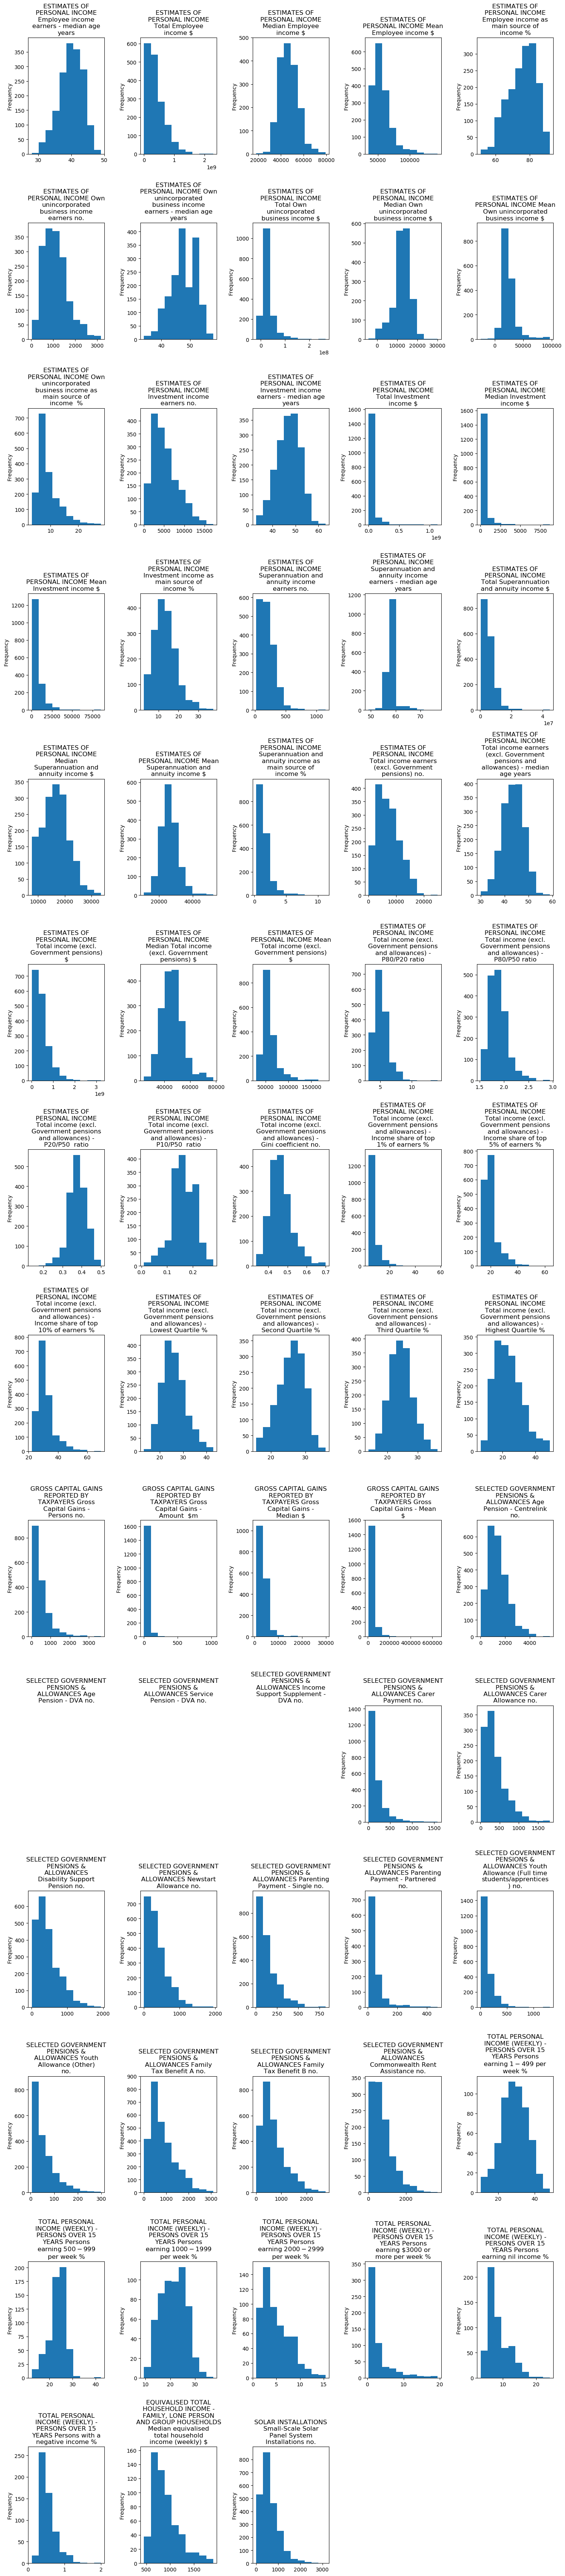

In [116]:
histo_plots(df.iloc[:,4:],5)

In [120]:
df.corr().iloc[:,-1].sort()

YEAR                                                                                                                                  0.170447
ESTIMATES OF PERSONAL INCOME Employee income earners no.                                                                              0.248601
ESTIMATES OF PERSONAL INCOME Employee income earners - median age  years                                                              0.183666
ESTIMATES OF PERSONAL INCOME Total Employee income $                                                                                  0.071821
ESTIMATES OF PERSONAL INCOME Median Employee income $                                                                                -0.175521
ESTIMATES OF PERSONAL INCOME Mean Employee income $                                                                                  -0.265248
ESTIMATES OF PERSONAL INCOME Employee income as main source of income %                                                               0.055253

In [130]:
solar = 'SOLAR INSTALLATIONS Small-Scale Solar Panel System Installations no.'
sort_series_abs(df.dropna(subset=[solar]
                         ).corr().loc[:,solar])[1:]

SELECTED GOVERNMENT PENSIONS & ALLOWANCES Age Pension - Centrelink no.                                                                0.646625
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Disability Support Pension no.                                                              0.574461
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Parenting Payment - Single no.                                                              0.572126
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Youth Allowance (Other) no.                                                                 0.560496
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Family Tax Benefit A no.                                                                    0.544680
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Commonwealth Rent Assistance no.                                                            0.539607
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Family Tax Benefit B no.                                                                    0.505005

# Initial Thoughts
Very interesting that there is a high correlation between number of individuals on government pensions and those earning annuities, and even moreso that there is a *negative* correlation with the share of high income earners and number of solar panels, which also flows through into total household income.

Obviously the first step I'm missing is *per household* solar panel information, as simply increasing the number of households in a given region also increases the chance there will be another solar panel installation. 

I'm also anticipating there will be some outlier suburbs etc. where there is zero probability of household solar panel installation, simply because there are no households (i.e. those comprised entirely of apartment blocks, if such a region exists).

I also wonder if there is a reason to explore *change* in installations year on year.

In [48]:
solar = 'SOLAR INSTALLATIONS Small-Scale Solar Panel System Installations no.'

In [134]:
df_fam = pd.read_csv('{}\CSV\Family and Community_ASGS.csv'.format(nb_path), na_values='-', thousands=',')

In [135]:
df = pd.merge(df, df_fam, how='inner', left_on=['CODE','YEAR','LABEL'], right_on=['CODE','YEAR','LABEL'])

In [49]:
df['Solar Per Household'] = df[solar]/df['HOUSEHOLDS BY TYPE Total households no.']

In [144]:
sort_series_abs(df.dropna(subset=[solar]
                         ).corr().loc[:,solar])[1:50]

DWELLING STRUCTURE Separate house  no.                                                            0.748155
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Age Pension - Centrelink no.                            0.648315
HOUSING SUITABILITY Dwellings with bedrooms spare no.                                             0.604056
ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  60-64 years no.                  0.592317
ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  65-69 years no.                  0.587060
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Disability Support Pension no.                          0.583603
ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  60-64 years no..2                0.582926
ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  65-69 years no..2                0.575826
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Parenting Payment - Single no.                          0.573784
ESTIMATED RESIDENT POPULATION (USUAL 

In [147]:
sort_series_abs(df.dropna(subset=['Solar Per Household']
                         ).corr().loc[:,'Solar Per Household'])[1:50]

POPULATION DENSITY Population density  persons/km2                                                                                   -0.674192
RENT & MORTGAGE PAYMENTS Average monthly household mortgage payment $                                                                -0.665854
RENT & MORTGAGE PAYMENTS Average monthly household rental payment $                                                                  -0.648200
HOUSING SUITABILITY Dwellings with no bedrooms needed or spare no.                                                                   -0.623128
OVERSEAS BORN POPULATION (PROPORTION OF TOTAL POPULATION) Total Born Overseas  %                                                     -0.616499
DWELLING STRUCTURE Flat or apartment  no.                                                                                            -0.607122
ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  55-64 years %                                                        0.604846

# Next level thoughts
Okay, so the data at least makes sense - there is a strong negative correlation between population density and solar installations per household, owing to some key factors regarding building composition within the region:
* More renters in the region result in less solar investment (they are unlikely to reap the long term capital benefits)
* Greater number of apartment buildings
* I'm not sure about this one, but number of households with neither rooms to spare nor rooms needed, so perfectly utilised. My best guess is this figure itself is closely associated with renting.

Some other observations leap out at me:
* The positive correlation with 55-64 year old residents
* The negative correlation with immigrants and non-citizens
* The negative correlation with overall income, but positive correlation with income between $500-999 per week
* Positive correlations with income earners' ages
* A *very* surprising negative correlation with gifts and donations! Goes to show that this particular "green" signal is not an indicator of altruistic behaviour.

It is also interesting to note the overwhelming amount of strong negative correlations, solar has a lot going against it apparently!

Annoyingly, there seem to be some direct duplicate columns in the dataset (note the "no..1 and no..2" variables) so I will need some way of eliminating these before running PCA and other ML techniques over the data to ensure that coefficients aren't distorted by this duplication.

# But that's just correlations
Time to delve into some more advanced modelling to see what jumps out!

In [ ]:
# Do linear regression and sort by coefficient per example investigation
# Probably do PCA first given the *large* amount of overlapping features

#probably do some exploration of na values?

In [ ]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

# Note: dropping solar (not solar per household) given I only want to predict installations per household.
# Including this would have too strong a tie.
df_scaled= scaler.fit_transform(df.drop[solar])

In [84]:
def clean_data(df, y_column, fill_mean_subset = None):
    '''
    A function to clean a dataframe and return X & y values for further processing. 
    Rows are removed where NaNs are present in response vector records.
    NaN values for all other features are filled with the mean of the feature.
    
    INPUT
    df - pandas dataframe 
    y_column - String. Name of column to be used as the response vector
    fill_mean_subset - String, column name. Allows the input of a column to "subset" when first completing
                        imputing missing numerical values with a series mean. E.g. if there is a categorical 
                        field of "year", allows imputing of null values with the mean of each year, rather 
                        than the mean of the overall series.  
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    '''    
    # Remove duplicate columns
    drop_cols = []
    check_cols = df.columns.tolist()
    check_cols.sort()
    w_end = len(check_cols)
    i = 0
    
    # Cycle through each column name
    while i < w_end:
        # assign a Check variable the the column name as a string
        # that name string should only include characters up to 1 character after the final space
        # e.g. "* %" or "* n"
        check_str = check_cols[i]
        check_str = check_str[:(check_str.rfind(" ")+2)]
        
        for col in check_cols[(i+1):]:
            # look forward in the list of column names for any other items matching CheckString & "*"
            # add any matches to a list to drop, drop from the "check" list as well so make further searches more efficient.
            # I'm almost certain there is a more efficient way to do this list/dict-wise
            if col.startswith(check_str):
                drop_cols.append(col)
                check_cols.remove(col)
                w_end -= 1
        i += 1  
    
    df.drop(drop_cols, axis = 1, inplace=True)
    
    # Drop rows with missing response values
    df = df.dropna(subset=[y_column], axis=0)
    y = df[y_column]
    
    #Drop response column
    df = df.drop(y_column, axis=1)
    
    # Fill numeric columns with the mean    
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    # First, fill with the mean of the subset based on given category
    if fill_mean_subset != None:
        index_reset = False
        index_names = list(df.index.names)
        
        # Filtering sucks with multi-indexing so temporarily reset the indexes for this action
        if fill_mean_subset in index_names:
            index_reset = True
            df.reset_index(inplace=True)

        #Check if subset variable is an index item
        for subset_item in df[fill_mean_subset].unique().tolist():
            for col in num_vars:
                df.loc[(df[fill_mean_subset] == subset_item) & (df[col].isnull()), col] = (
                        df.loc[df[fill_mean_subset] == subset_item].mean())
        
        if index_reset:
            df.set_index(index_names, inplace=True)

    # For any remaining nulls, fill with the mean of the overall series
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # OHE the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    # Fill OHE NaNs with 0
    # Get list of columns after OHE that were not in the "numeric" list from earlier, using set function for speed.
    cat_vars = list(set(df.columns.tolist()) - set(num_vars.tolist()))
    for var in cat_vars:
        df[var].fillna(0, inplace=True)
    
    X = df
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df, 'Solar Per Household', 'YEAR')    

ValueError: Must have equal len keys and value when setting with an iterable

In [ ]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

In [ ]:
def clean_fit_linear_mod(df, response_col, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test

    OUTPUT:
    X - cleaned X matrix (dummy and mean imputation)
    y - cleaned response (just dropped na)
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model

    This function cleans the data and provides the necessary output for the rest of this notebook.
    '''
    #Dropping where the salary has missing values
    df  = df.dropna(subset=['Salary'], axis=0)

    #Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)

    #Pull a list of the column names of the categorical variables
    cat_df = df.select_dtypes(include=['object'])
    cat_cols = cat_df.columns

    #dummy all the cat_cols
    for col in  cat_cols:
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)], axis=1)


    # Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df = df.apply(fill_mean, axis=0)

    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [ ]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

In [ ]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

#Run this cell to pass your X and y to the model for testing
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [ ]:
# Do something else from supervised learning 
# AdaBoost baby! Given the large number of strong correlations above, and relatively unskewed historgram plots,
# the main weakness of AdaBoost being sensitivity to outliers and noisy data is minimal.

# Maybe try SVM while I'm at it, since the number of rows isn't huge, but the number of dimensions is

# Use feature importance just like in the first project to get at this item